In [79]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from numpy import linalg as lin

''' Provides an abstraction of a data point as a Euclidean point with (x,y) coordinates. '''
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return '(' + str(self.x) + ',' + str(self.y) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    ''' Returns the point in the given list that is closest (in terms of Euclidean distance) to this point. '''
    def closest_point(self, points):
        shortest_dist = float('inf')
        closest_point = 0
        for point in points:
            dist = math.sqrt((point.x - self.x)**2 + (point.y - self.y)**2)
            if dist < shortest_dist:
                shortest_dist = dist
                closest_point = point
        return closest_point

In [80]:
''' Returns the point that is closest to the average of the given list of Point objects. '''
def average_point(points):
    avg_x = 0.
    avg_y = 0.
    for point in points:
        avg_x += point.x
        avg_y += point.y
    avg_x /= len(points)
    avg_y /= len(points)
    
    avgPt = Point(avg_x, avg_y)
    closestToAvg = avgPt.closest_point(points)
    return closestToAvg
    #return avgPt

In [81]:
''' K medioids centroid initialization. '''
def init_k_medioids(points, k):
    return random.sample(points, k)

In [82]:
''' Kmeans++ centroid initialization. '''
def init_kpp(points, k):
    # Choose first centroid uniformly at random
    centroids = [random.choice(points)]
    
    # Choose the remaining k-1 centroids
    for i in range(1, k):
        # For each point, calculate the squared distance between it and the closest already-chosen centroid
        distances = [None for j in range(len(points))]
        for j in range(len(points)):
            closest_cent = points[j].closest_point(centroids)
            distances[j] = (closest_cent.x - points[j].x)**2 + (closest_cent.y - points[j].y)**2

        # Generate probability weights proportional to the previously calculated squared distances
        weights = [distances[j] / sum(distances) for j in range(len(distances))]

        # Choose a new centroid randomly from the remaining points 
        centroids.append(np.random.choice(points, p=weights))

    return centroids

In [83]:
''' Creates a scatterplot of the given clusters, color-coding by cluster and highlighting centroids in red. '''
def plot_clusters(points, clusters):
    colors = ['blue', 'green', 'cyan', 'magenta', 'yellow', 'black']
    centroids = clusters.keys()
    
    for point in points:
        if point in centroids:
            plt.scatter(point.x, point.y, color='red')
        else:
            for centroid in clusters:
                if point in clusters[centroid]:
                    colorInd = centroids.index(centroid) % len(colors)
            plt.scatter(point.x, point.y, color=colors[colorInd])
    plt.show()

In [84]:
''' Performs the k-means clustering algorithm using the given centroid initialization method. '''
def k_means(centroid_init_func, points, k):
    # Initialize the centroids by randomly choosing k points from the dataset
    centroids = centroid_init_func(points, k)
    previous_centroids = []
    
    # Assign clusters and reassign centroids until they stop changing
    while centroids != previous_centroids:
        previous_centroids = [cent for cent in centroids]
        clusters = {cent: [cent] for cent in centroids}
        
        # Assign each point to the closest centroid
        for point in points:
            if point not in centroids:
                # Find the centroid closest to the point and add it to its cluster
                closest_cent = point.closest_point(centroids)
                clusters[closest_cent].append(point)
                
        # Plot the current clusters
        plot_clusters(points, clusters)
                
        # Keep track of the previous set of centroids
        last_centroids = centroids

        # Reassign centroids 
        for centroid in clusters:
            centroids.append(average_point(clusters[centroid]))    # Assign the new centroid
            centroids.remove(centroid)    # Delete the old centroid
    
    # Plot the final clusters
    #plot_clusters(points, clusters)
    
    return centroids, clusters

In [85]:
class SpectralCluster(object):
    def __init__(self, data, k, sigma=1):
        self.k = min(k, data.shape[0])
        self.orig_points = data.as_matrix()
        self.centers = None
        self.points = None
        self._spect_(sigma)
        self.clusters = defaultdict(list)
      
    def _spect_(self, sigma):

        num = self.orig_points.shape[0] 
        pts = self.orig_points
        mat = np.zeros((num, num))
        for i in range(k):
            mat[i, :] = lin.norm(pts[i] - pts, axis=1) ** 2
        mat = np.exp(-mat / (2 * np.power(sigma, 2)))
        np.fill_diagonal(mat, 0)
        
        d = np.diag(np.reciprocal(np.power(mat.sum(axis=1), .5)))
        lap = d * mat * d
        x, y = lin.eig(L)
        pair = list(zip(x,y))
        pair.sort(key=lambda x: x[0], reverse=True)
        largest_eig = [y for x, x in pair[:self.k]]
        mat_X = np.array(largest_eig).T
        mat_Y = mat_X / (np.sqrt(mat_X**2).sum(axis=1).reshape(-1,1))
        self.points = mat_Y
        self.centers = pd.DataFrame(mat_Y).sample(self._k).as_matrix()
   

    def _center_(self, pt):
        distance = lin.norm(self.points[pt] - self.centers, axis=1)
        minimum = np.argmin(distance)
        return minimum
    
    def _assignments_of_points(self):
        c = defaultdict(list)
        for pt in self.points:
            index = self._center_(pt)
            c[index].append(pt)
        self.clusters = c
        
    def centroids(self):
        self._assignments_of_points()
        new = np.zeros(self.centers.shape)
        for index, c in sorted(self.clusters).items():
            pts_in_cluster = np.array(c)
            average = np.sum(pts_in_cluster, axis = 0)
            average = average/pts_in_cluster.shape[0]
            new[index] = average
        self.centers = new
    
    def _orig(self):
        val = self.clusters.values()
        orig = [[self.orig_points[i] for i in c for c in val]]
        return orig
    def prog(self, n=20):
        for i in range(n):
            cent = deepcopy(self.centers)
            self.centroids()
            if i != 0: 
                if self.centers == cent:
                    break
        return zip(self.centers, self._orig())

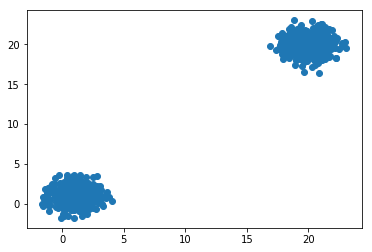

In [86]:
''' Generate samples from a normal distribution centered at (1,1). '''
mean1 = (1,1)
cov1 = ((1,0), (0,1))
cluster1 = np.random.multivariate_normal(mean1, cov1, size=500)

''' Generate samples from a normal distribution centered at (20,20). '''
mean2 = (20, 20)
cov2 = ((1,0), (0,1))
cluster2 = np.random.multivariate_normal(mean2, cov2, size=500)

''' Concatenate the two sample sets into one dataset. '''
all_data = []
for x in range(500):
    all_data.append(cluster1[x])
    all_data.append(cluster2[x])
all_data = np.asmatrix(all_data)

''' Plot the concatenated dataset, pre-clustering. '''
plt.scatter(all_data[:,0], all_data[:,1])
plt.show()

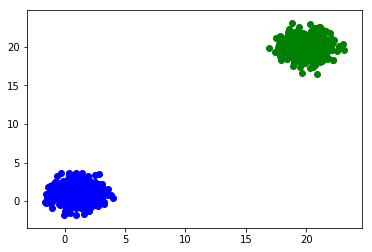

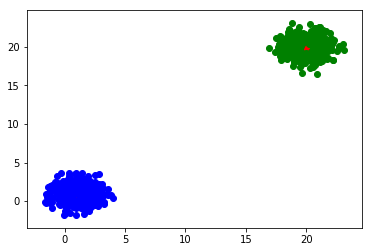

In [87]:
''' Convert the data into Point objects. '''
all_data = np.array(all_data)
points = [Point(point[0], point[1]) for point in all_data]

''' Perform K-Means on the data. '''
centroids, clusters = k_means(init_kpp, points, 2)